In [124]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.use('module://matplotlib_inline.backend_inline')
import yaml
import time
import pickle as pkl
import os
import sys
import numpy as np
from matplotlib import cm
from scipy import signal
from scipy.signal import butter, welch, filtfilt, periodogram, savgol_filter
import pandas as pd
import glob
from scipy.optimize import curve_fit
from scipy.optimize import fminbound
import scipy.linalg as linalg
import scipy as sp
# sys.path.append("/home/cryo/.local/lib/python3.10/site-packages/")
# import nbimporter

plt.ion()
%matplotlib inline

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE, facecolor='white') 

# Import useful functions

In [125]:
# Import useful wrapper functions

sys.path.append("/home/cryo/docker/pysmurf/dev/v8.0.0-rc3_rfsoc/pysmurf/scratch/adroster")
from utils import *

# Define useful functions

In [126]:
def welch_IQ(iq, fs,  plot=True, welch_nperseg=2**18, title='', show_plot=True):
    i = iq.real
    q = iq.imag
    ffi, pxxi = welch(i,fs=fs, nperseg=welch_nperseg)
    ffq, pxxq = welch(q,fs=fs, nperseg=welch_nperseg)

    # scale to dBc/Hz by the voltage magnitude
    magfac = np.mean(q)**2 + np.mean(i)**2
    pxxi_dbc = 10. * np.log10(pxxi / magfac)
    pxxq_dbc = 10. * np.log10(pxxq / magfac)


    if plot:
        plt.gca().semilogx(ffi,pxxi_dbc,linestyle='-',label=f'i {title}')
        plt.gca().semilogx(ffq,pxxq_dbc, linestyle='--',label=f'q {title}')
        plt.ylabel('dBc/Hz')
        plt.xlabel('Frequency (Hz)')
        plt.title(title)
        plt.legend(loc='lower left')
        if show_plot: plt.show()
    return

def freqSweep(S, band, start_freq=-250, stop_freq=250, subband=None, tone_power=None, n_avg=1, makeplot=False):
    """
    Inputs:
    S (obj): PySMuRF control instance
    start_freq (int): start frequency of sweep in the IF [MHz]
    stop_freq (int): stop frequency of sweep in the IF [MHz]
    subband:
    tone_power (int): int between 0 and 15. Each integer is 0.5 dBm of power. Not much dynamic range here. Defaults to 12 due to config file.
    n_avg (int): nubmer of times to average. this is a sweep-to-sweep average, analogous to averaging on a VNA
    makeplot (bool): 

    Outputs:
    freqs (ndarray): real-valued 1D array of frequenies (RF, not IF)
    resp_avg (ndarray): complex-valued 1D array of response
    """
    #adapted from S.find_freq()
    band_center = S.get_band_center_mhz(band)
    if subband is None:
        start_subband = S.freq_to_subband(band, band_center + start_freq)[0]
        stop_subband = S.freq_to_subband(band, band_center + stop_freq)[0]
        step = 1
        if stop_subband < start_subband:
            step = -1
        subband = np.arange(start_subband, stop_subband+1, step)
    else:
        sb, sbc = S.get_subband_centers(band)
        start_freq = sbc[subband[0]]
        stop_freq  = sbc[subband[-1]]

    # Turn off all tones in this band first.  May want to make
    # this only turn off tones in each sub-band before sweeping,
    # instead?
    S.band_off(band)

    if tone_power is None:
        tone_power = S._amplitude_scale[band]
        S.log('No tone_power given. Using value in config ' +
                 f'file: {tone_power}')

    #the following for loop does an amplitude sweep n_avg times, reads the response, and addes the response array to resp_tot
    #resp_tot has shape (n_avg, 31*n_channels). n_channels is the number of processed channels + 1; there are 31 frequencies per channel.
    S.log(f'Sweeping across frequencies {start_freq + band_center}MHz to {stop_freq + band_center}MHz. Averaging {n_avg} traces.')
    BW_MHz = 500
    freqs_per_channel = 31
    n_channels = int(np.ceil((S.get_number_processed_channels(band))*(stop_freq - start_freq)/BW_MHz)+1)
    resp_shape = (n_avg, freqs_per_channel*n_channels)
    #resp_arr = np.zeros(resp_shape, dtype = np.complex_)
    resp_arr = []
    for n in range(n_avg):
        f, resp = S.full_band_ampl_sweep(band, subband, tone_power, n_read=2) #n_read doesn't actually do anything; must be legacy code from previous SMuRF implementations
        
        #below is adapted from S.find_all_peak()
        # Stack all the frequency and response data into a
        # Frequency array is the same on every iteration, so only need to find & sort frequencies once
        if n == 0:
            sb, _ = np.where(f !=0)
            idx = np.unique(sb)
            f_stack = np.ravel(f[idx])
            # Frequency is interleaved, so sort it
            s = np.argsort(f_stack)
            f_stack = f_stack[s]
            freqs = f_stack

            # convert frequencies from IF to the RF
            if band is not None:
                bandCenterMHz = S.get_band_center_mhz(band)
                scale = 1
                if np.max(f_stack) > 1.0E8:
                    self.log('Frequency is probably in Hz. Converting to MHz')
                    scale = 1.0E-6
                freq_rf = bandCenterMHz - freqs*scale
            else:
                freq_rf = bandCenterMHz - freqs
            
        r_stack = np.ravel(resp[idx])
    
        # response is also interleaved, so sort it
        r_stack = r_stack[s]

        #append the sorted & stacked response array to resp_arr
        #resp_arr[n,:] = r_stack
        resp_arr.append(r_stack)

    #Frequencies are just f_stack; Average the response

    resp_arr = np.array(resp_arr)
    resp_avg = np.mean(resp_arr, axis=0)
    
    # Break apart the data to find phase, deriv of phase
    angle = np.unwrap(np.angle(resp_avg))
    x = np.arange(len(angle))
    p1 = np.poly1d(np.polyfit(x, angle, 1))
    angle -= p1(x)
    grad_kernel_width = 8
    grad = np.convolve(angle, np.repeat([1,-1], grad_kernel_width), mode='same')
    #grad_kernel_width is number of samples to take after a point to calculate gradient; default is 8

    #find the amplitude
    amp = np.abs(resp_avg)
    
    #calculating rolling median. Adapted from S.find_peaks()   
    # Calculate the rolling median. This uses pandas. This is analogous to smoothing on a VNA.
    import pandas as pd
    med_amp = pd.Series(amp).rolling(window=50, center=True, min_periods=1).median()

    # convert frequencies from IF to the RF
    if band is not None:
        bandCenterMHz = S.get_band_center_mhz(band)
        scale = 1
        if np.max(f_stack) > 1.0E8:
            self.log('Frequency is probably in Hz. Converting to MHz')
            scale = 1.0E-6
        freq_rf = bandCenterMHz - freqs*scale
    else:
        freq_rf = bandCenterMHz - freqs
    
    #plotting
    if makeplot:
        plt.ion()

        fig, ax = plt.subplots(2, figsize=(8,6), sharex=True)

        # Plot response
        ax[0].plot(freq_rf, amp)
        ax[0].plot(freq_rf, med_amp)

        ax[1].plot(freq_rf, grad)
        ax[1].set_ylim(-2, 20)

        ax[0].set_ylabel('Amp.')
        ax[1].set_ylabel('Deriv Phase')
        ax[1].set_xlabel('Freq. [MHz]')

        # Text label
        text = ''
        if band is not None:
            text += f'Band: {band}' + '\n'
            text += f'Center Freq: {bandCenterMHz} MHz' + '\n'
        ax[0].text(.025, .975, text, transform=ax[0].transAxes, ha='left',
            va='top')

    
    return freq_rf, resp_avg

# find the frequency between parity bands
def lorentzian(f, f0, Gc, Gr, g, Omega, slope):
    Delta = 2*np.pi*(f - f0)
    S21 = 1 - (Gc/2/g)*(1-Delta*1j/g)/(1+(Delta/g)**2+(2*np.pi*Omega)**2/g/Gr) + slope*Delta
    return S21
    
def invertedDoubleLorentzian(f, f0_1, f0_2, Gc_1, GC_2, Gr_1, Gr_2, g_1, g_2, Omega_1, Omega_2, baseline, scale, slope):
    '''
    Eq. E22 in the design paper
    '''
    lorentzian1 = lorentzian(f, f0_1, Gc_1, Gr_1, g_1, Omega_1, slope)
    lorentzian2 = lorentzian(f, f0_2, Gc_2, Gr_2, g_2, Omega_2, slope)
    S21 = baseline + scale*(lorentzian1 + lorentzian2)
    return np.abs(S21)

def negInvertedDoubleLorentzian(f, f0_1, f0_2, Gc_1, GC_2, Gr_1, Gr_2, g_1, g_2, Omega_1, Omega_2, baseline, scale, slope):
    '''
    Eq. E22 in the design paper
    '''
    return -invertedDoubleLorentzian(f, f0_1, f0_2, Gc_1, GC_2, Gr_1, Gr_2, g_1, g_2, Omega_1, Omega_2, baseline, scale, slope)

def takeDebugData(S, band, channel, nsamp, plot=True, welch_nperseg=2**18, show_plot=True, channel_mode=0):
    timestamp = S.get_timestamp()
    filename = f'{timestamp}_multi_channel_b{band}'
    if channel is not None:
        filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
    i,q,sync = S.take_debug_data(band=band,channel=channel,rf_iq=True,nsamp=nsamp,filename=filename, single_channel_readout=channel_mode) 
    i = i / (1.2)
    q = q / (-1.2)
    iq = i + 1j * q
    if plot: 
        fs = S.get_channel_frequency_mhz(band) * 1.0E6
        welch_IQ(iq, fs, welch_nperseg, title=filename, show_plot=show_plot)
        ### save plots 
        fig = plt.gcf()
        #plt.savefig(f'/data/smurf_data/mkid_1tone_streaming_metadata/_Figs/{filename}_psd', fmt='tiff')
        plt.show()
    return iq, sync, filename

def butterworth_filter(data, fs, cutoff_hz=200, order=1):
    b, a = butter(N=order, Wn=cutoff_hz, btype='low', fs=fs)
    zi = sp.signal.lfilter_zi(b, a)
    filt_data, _ = sp.signal.lfilter(b, a, data, zi=zi*data[0])
    return filt_data

# Initialize a pysmurf control instance

In [127]:
import pysmurf.client
import epics
import os
import time

%matplotlib inline

epics_prefix="smurf_server_s3"
config_file=os.path.abspath("/usr/local/src/pysmurf/cfg_files/lab1/experiment_lab1_rfsoc.cfg")
S = pysmurf.client.SmurfControl(epics_root=epics_prefix,cfg_file=config_file,setup=False,make_logfile=False,shelf_manager="shm-smrf-sp01")

## Dump versions of everything
# Python version
print(sys.version)
import pysmurf
pysmurf.__version__
cwd=os.getcwd()
os.chdir('/usr/local/src/pysmurf/')
#print(str(!git branch))
#print(!git rev-parse --short HEAD)
print(S.get_fpga_git_hash_short())
print(S.config.filename)

[ 2025-11-21 20:55:59 ]  ERROR : band 0 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-11-21 20:55:59 ]  ERROR : band 1 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-11-21 20:55:59 ]  ERROR : band 2 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-11-21 20:55:59 ]  ERROR : band 3 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-11-21 20:55:59 ]  ERROR : band 4 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-11-21 20:55:59 ]  ERROR : band 5 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-11-21 20:55:59 ]  ERROR : band 6 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-11-21 20:55:59 ]  ERROR : band 7 is present in pysmurf cfg file, but its bay is not enabled!
3.8.10 (default, Mar 13 2023, 10:26:41) 
[GCC 9.4.0]
ed145d0
/usr/local/src/pysmurf/cfg_files/lab1/experiment_lab1_rfsoc.cfg


In [128]:
S.log('starting')

[ 2025-11-21 20:55:59 ]  starting


## Define the LO frequency

In [129]:
LO_freq_MHz = 9150

## Set SMuRF parameters

In [130]:
S.log_file

AttributeError: 'SmurfControl' object has no attribute 'log_file'

In [131]:
S.all_off()

[ 2025-11-21 20:56:03 ]  Turning off tones
[ 2025-11-21 20:56:20 ]  Turning off flux ramp
[ 2025-11-21 20:56:20 ]  Turning off all TES biases


In [132]:
S.get_band_center_mhz(band=0)

8400.0

The baseband center of 4250 MHz is a legacy number from old smurf versions. The RFSoC board has a baseband center of 750 MHz. But the LO mixes this up to 8.5 GHz (9250-750=8500.) Let's tell the software what's what:

In [133]:
S.set_band_center_mhz(0,LO_freq_MHz-750)

In [134]:
S.get_band_center_mhz(band=0)

8400.0

# Thru fridge
Use SMuRF to do a VNA-like sweep of the frequency band; save the frequency and response arrays.

[ 2025-11-13 21:02:18 ]  No tone_power given. Using value in config file: 12
[ 2025-11-13 21:02:18 ]  Sweeping across frequencies 8400.0MHz to 8420.0MHz
[ 2025-11-13 21:02:18 ]  Working on band 0
[ 2025-11-13 21:02:22 ]  serial find freq complete ; etaScanInProgress = 0


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


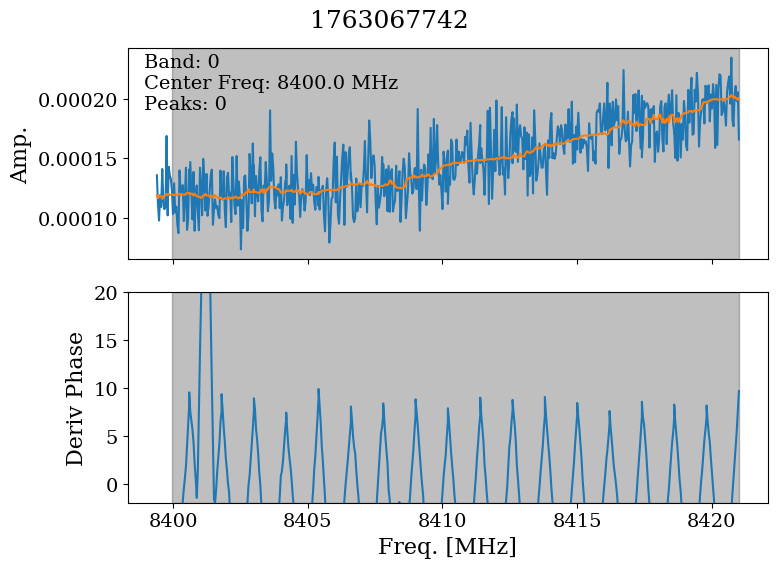

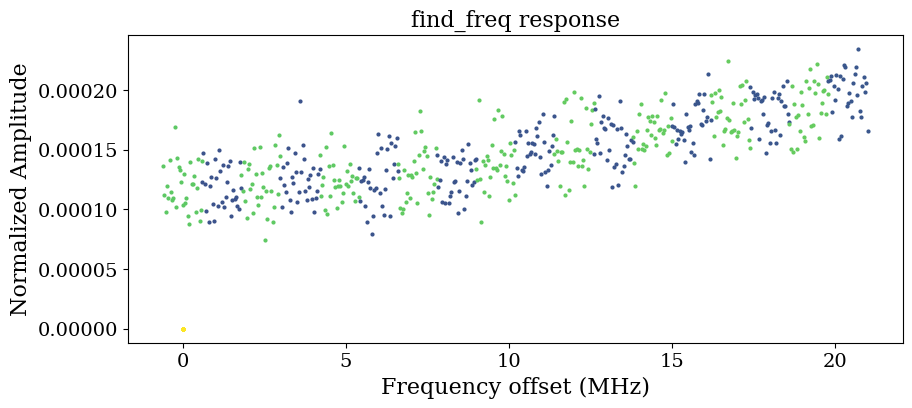

In [9]:
f, resp = S.find_freq(band=0, start_freq = 0, stop_freq = 20, make_plot=True, show_plot=True, grad_cut =.5,\
                      amp_cut = .8, pad = 12, min_gap = 20)

[ 2025-11-17 23:47:31 ]  No tone_power given. Using value in config file: 12
[ 2025-11-17 23:47:31 ]  Sweeping across frequencies 8390.0MHz to 8420.0MHz. Averaging 1 traces.
[ 2025-11-17 23:47:31 ]  Working on band 0
[ 2025-11-17 23:47:36 ]  serial find freq complete ; etaScanInProgress = 0


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


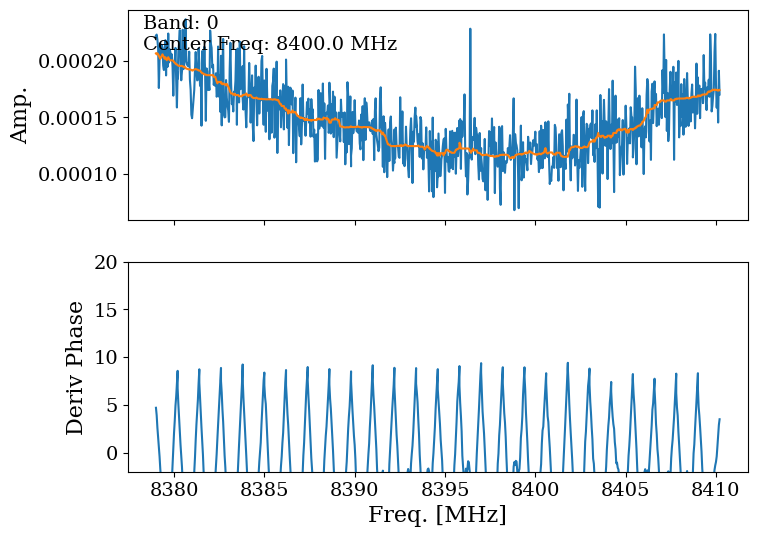

In [11]:
f2, resp2 = freqSweep(S, band=0, start_freq=-10, stop_freq=20, subband=None, tone_power=None, n_avg = 1, makeplot=True)

# Look for the qubits

From VNA scans, H2 qubits should be located at:
* H2Q1 = 8365.5 MHz
* H2Q2 = 8418.1 MHz
* H2Q3 = 8470.5 MHz

In [135]:
f_qubit1 = 8365.5
f_qubit2 = 8418.1
f_qubit3 = 8470.5

### H2Q1

In [136]:
relative_start = -110
relative_stop = -80

LO_freq = 9150
LO_power = 10

smurf_start = LO_freq - (750+relative_start)
smurf_stop = LO_freq - (750+relative_stop)
print(f"\nSMuRF start: {smurf_start} MHz")
print(f"SMuRF stop: {smurf_stop} MHz")
S.log('SMURF range is from {} to {} MHz'.format(smurf_start,smurf_stop))


SMuRF start: 8510 MHz
SMuRF stop: 8480 MHz
[ 2025-11-21 20:56:21 ]  SMURF range is from 8510 to 8480 MHz


In [13]:
## now average the spectrum several times to improve SNR near the qubit
n_avg = 10

f3, resp3 = freqSweep(S, band=0, start_freq=-10, stop_freq=20, subband=None, tone_power=None, n_avg = n_avg, makeplot=False)

amp = np.abs(resp3)
phase = np.angle(resp3)

[ 2025-11-13 21:24:20 ]  No tone_power given. Using value in config file: 12
[ 2025-11-13 21:24:20 ]  Sweeping across frequencies 740.0MHz to 770.0MHz. Averaging 10 traces.
[ 2025-11-13 21:24:21 ]  Working on band 0
[ 2025-11-13 21:24:25 ]  serial find freq complete ; etaScanInProgress = 0
[ 2025-11-13 21:24:25 ]  Working on band 0
[ 2025-11-13 21:24:29 ]  serial find freq complete ; etaScanInProgress = 0
[ 2025-11-13 21:24:29 ]  Working on band 0
[ 2025-11-13 21:24:34 ]  serial find freq complete ; etaScanInProgress = 0
[ 2025-11-13 21:24:34 ]  Working on band 0
[ 2025-11-13 21:24:38 ]  serial find freq complete ; etaScanInProgress = 0
[ 2025-11-13 21:24:38 ]  Working on band 0
[ 2025-11-13 21:24:42 ]  serial find freq complete ; etaScanInProgress = 0
[ 2025-11-13 21:24:42 ]  Working on band 0
[ 2025-11-13 21:24:47 ]  serial find freq complete ; etaScanInProgress = 0
[ 2025-11-13 21:24:47 ]  Working on band 0
[ 2025-11-13 21:24:51 ]  serial find freq complete ; etaScanInProgress = 0
[

## Find the center of the parity bands, readout at that frequency
We fit a double Lorentzian to the parity bands using Eq. 22 from the characterization paper. Then we minimize (the negative of) this fit function to find the center of the parity bands.

In [137]:
# initial guess
center_parity_bands_MHz = 8391.5

f0_1 = f_qubit2
Gc_1 = 10 # MHz
Gr_1 = 10 # Mhz
g_1 = 5 # MHz
Omega_1 = 1 # MHz
f0_2 = f_qubit2+2.5
Gc_2 = 6 # MHz
Gr_2 = 6 # Mhz
g_2 = 3 # MHz
Omega_2 = 1 # MHz
scale = .001
baseline = 0.02

# Fit to fit function
p0 = (f0_1, f0_2, Gc_1, Gc_2, Gr_1, Gr_2, g_1, g_2, Omega_1, Omega_2, scale, baseline)
bounds = ((8300, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),(8600,8600,20,20,20,20,20,20,20,20,1,1))
#popt, pcov = curve_fit(invertedDoubleLorentzian, f3, amp, p0 = p0, bounds = bounds)

# find the center of the parity bands
f0_1 = p0[0]
f0_2 = p0[1]
#center_parity_bands_MHz = fminbound(negInvertedDoubleLorentzian, f0_1, f0_2, popt)
f0_1 = center_parity_bands_MHz - .5
f0_2 = center_parity_bands_MHz + .5

In [ ]:
## plot the results
plt.figure(figsize=(7,8))
plt.subplot(2,1,1)
plt.plot(f3, amp)
#plt.plot(f3, invertedDoubleLorentzian(f3, *popt), 'r-', label = 'fit')
plt.axvline(x=f0_1, color='r', linestyle='--', label=f'{f0_1} MHz')
plt.axvline(x=f0_2, color='r', linestyle='--', label=f'{f0_2} MHz')
plt.axvline(x=center_parity_bands_MHz, color='g', linestyle='--', label=f'{center_parity_bands_MHz} MHz')
#plt.axis([8360,8380,-.0001,.0003])
plt.title('Magnitude')
plt.legend()
plt.subplot(2,1,2)
plt.plot(f3, phase)
plt.title('Phase')
plt.suptitle(f'H2Q1, frequency scan with {n_avg} averages')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Send a tone at the center of the parity bands

Recall that SMuRF only outputs tones between 250 - 1000 MHz which then get mixed up to the GHz. Therefore, the center of the parity bands in the IF is  $c_{pb}^{IF} = 750 + |f_{center}^{RF} - c_{pb}^{RF}|$, where $f_{center}^{RF}$ is the band center in the RF, typically 8400 MHz, and $c_{pb}^{RF}$ is the center of th parity bands in the RF.

We also need to tell SMuRF that the band center is 750 MHz. pySMuRF will throw an error if you try to place a tone more than 500 MHz from the band center.

In [18]:
S.get_channel_frequency_mhz(0)

2.4

In [51]:
print(channel)

NameError: name 'channel' is not defined

In [19]:
print(center_parity_bands_MHz)

8391.5


In [15]:
S.all_off()
# amp_readout_freq = center_parity_bands_MHz
S.set_band_center_mhz(0, LO_freq_MHz-750)
amp_readout_freq = 750 + np.abs(S.get_band_center_mhz(0)-center_parity_bands_MHz)
my_log = f'Sending fixed tone at {amp_readout_freq} MHz'
print(my_log)
S.log(my_log)

S.set_band_center_mhz(0, 750)
(band,channel)=S.set_fixed_tone(amp_readout_freq,12)

#S.run_serial_eta_scan(0)

[ 2025-11-17 23:47:50 ]  Turning off tones
[ 2025-11-17 23:48:06 ]  Turning off flux ramp
[ 2025-11-17 23:48:06 ]  Turning off all TES biases
Sending fixed tone at 758.5 MHz
[ 2025-11-17 23:48:07 ]  Sending fixed tone at 758.5 MHz


## Read I & Q at the center of the parity bands
At frequency = channel, use takeDebugData() to read I & Q. Then FFT the results (using the Welch method to smooth the psd). We can plot the psd of I, Q, or the amplitude and phase of I+iQ. Most of the signal will be in the phase.

[ 2025-11-13 21:17:54 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 448
[ 2025-11-13 21:17:54 ]  Writing to file : /data/smurf_data/20251113/1763068577/outputs/1763068674_single_channel_b0ch448.dat
[ 2025-11-13 21:17:54 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 33554432
[ 2025-11-13 21:17:54 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2025-11-13 21:17:54 ]  Data acquisition in progress...
[ 2025-11-13 21:17:54 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2025-11-13 21:18:10 ]  Done taking data


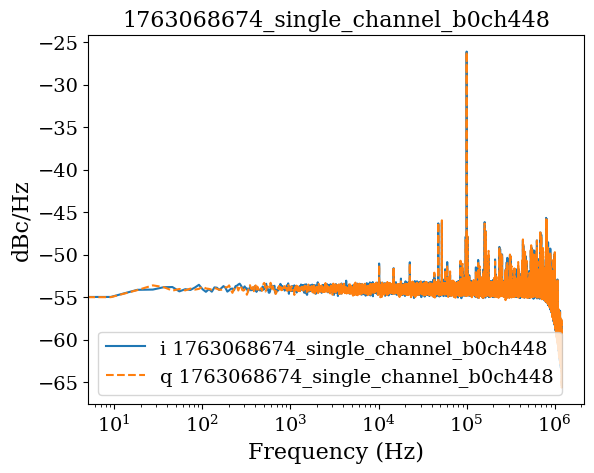

<Figure size 640x480 with 0 Axes>

In [30]:
iq, sync, filename = takeDebugData(S, band=band, channel=channel, nsamp=2**25, 
                                   plot=True, show_plot=True, channel_mode=2)

## Plot amp, phase of IQ

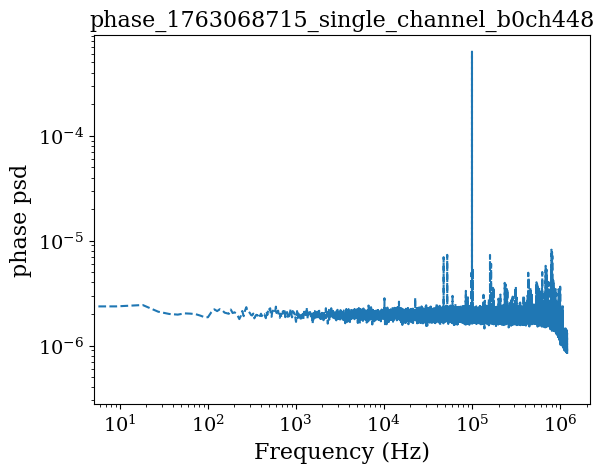

Text(0.5, 1.0, 'amplitude_1763068715_single_channel_b0ch448')

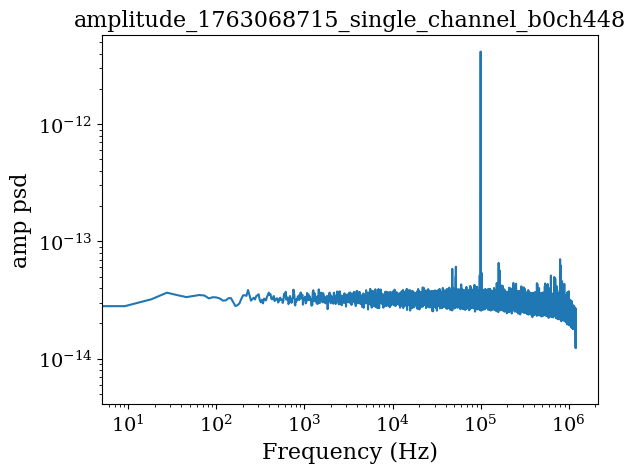

In [31]:
fs = S.get_channel_frequency_mhz(band) * 1.0E6

ffamp, pxxa = welch(np.abs(iq),fs=fs, nperseg=2**18)
ffphase, pxxph = welch(np.angle(iq),fs=fs, nperseg=2**18)

timestamp = S.get_timestamp() 
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
plt.gca().loglog(ffphase,pxxph, linestyle='--',label=f'phase {filename}')
plt.ylabel('phase psd')
plt.xlabel('Frequency (Hz)')
plt.title('phase_'+filename)
plt.show()

plt.gca().loglog(ffamp,pxxa,linestyle='-',label=f'amp {filename}')
plt.ylabel('amp psd')
plt.xlabel('Frequency (Hz)')
plt.title('amplitude_'+filename)


In [58]:
# fit to Lorentzian
# initial guess
S0_guess = np.max(pxxph)
F_guess = .3
peak_freq_guess = ffphase[np.argmax(pxxph)]
p0 = (2e-1, F_guess, 50, 1e-5)
#mid_indx = int(len(ffphase)//100)
#sigmas = np.ones(mid_indx)
#sigmas[:int(mid_indx/10)] = .4
#popt, pcov = curve_fit(corrected_lorentzian_psd, ffphase, pxxph, p0 = p0)

print(p0)
print(popt)

plt.gca().loglog(ffphase,pxxph, linestyle='--')
#plt.gca().loglog(ffphase, corrected_lorentzian_psd(ffphase, *popt), 'r-', label = 'fit, $\Gamma_p$={:d}'.format(int(popt[2])))
plt.ylabel('phase psd')
plt.xlabel('Frequency (Hz)')
plt.title('phase_'+filename)
plt.legend()
plt.show()

(0.2, 0.3, 50, 1e-05)


NameError: name 'popt' is not defined

### Use a Butterworth lowpass filter with cutoff freq = 500 Hz to smooth the time domain signal; plot the results

In [59]:
fs = S.get_channel_frequency_mhz(band) * 1.0E6

cutoff_hz = 500
order = 2

butter_ivals = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.real(iq), fs=fs)
butter_qvals = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.imag(iq), fs=fs)

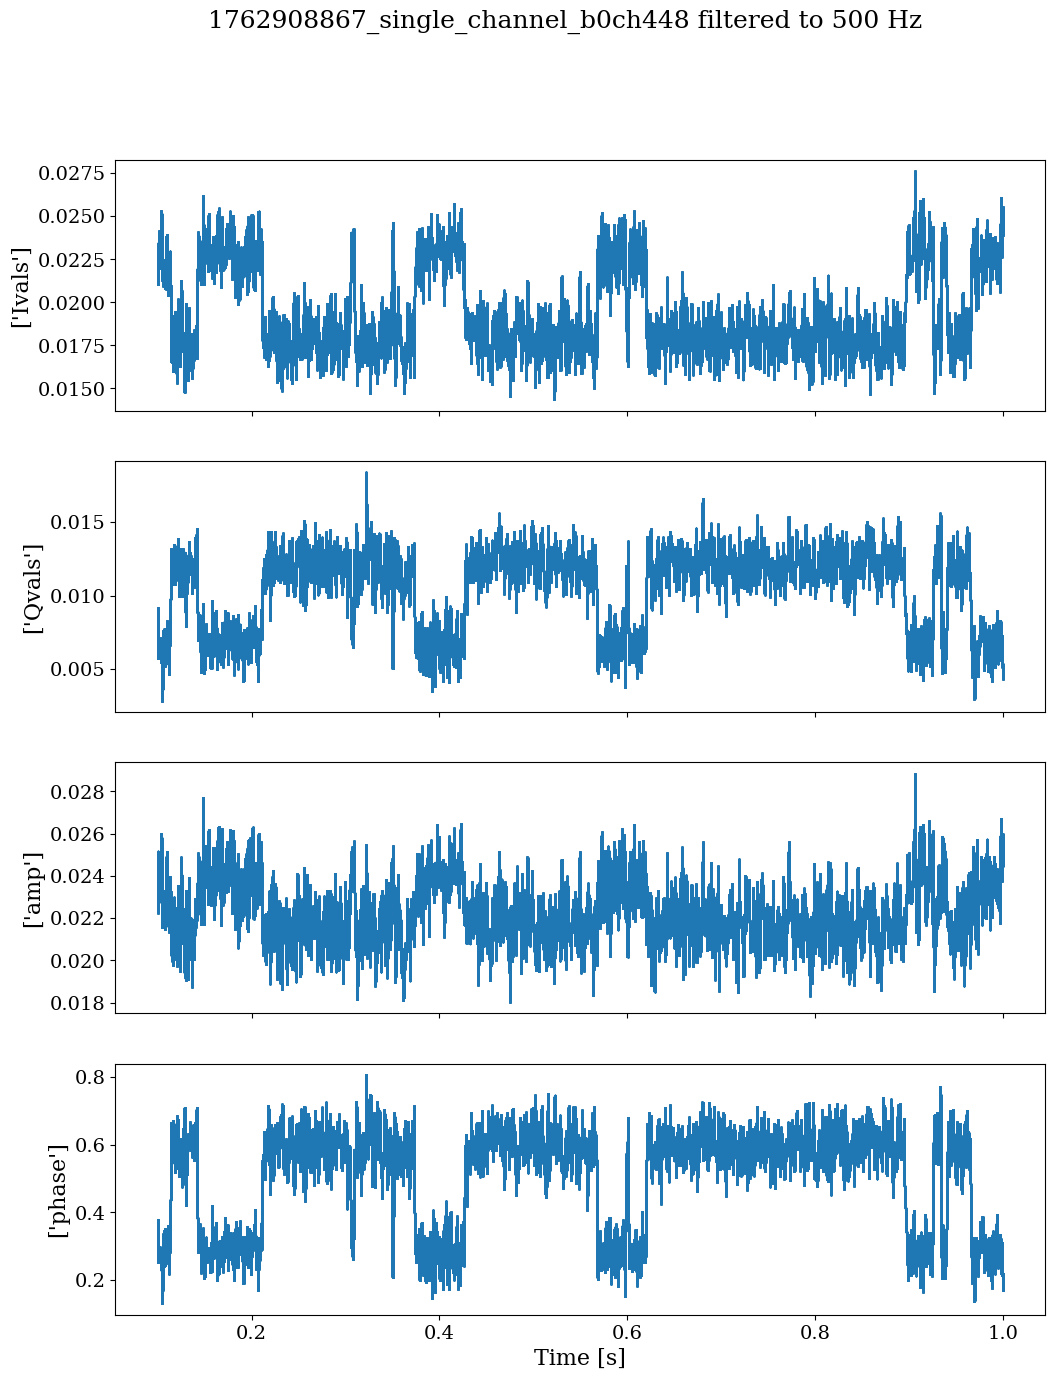

In [60]:
start_plot_time_s = 0.1
stop_plot_time_s = 1

## Find indices that best match times
times = np.arange(len(iq)) / fs
start_plot_idx = np.argmin(np.abs(times - start_plot_time_s))
stop_plot_idx = np.argmin(np.abs(times - stop_plot_time_s))

fig, ax = plt.subplots(4,1, figsize=(12,15), sharex=True)
ax[0].plot(times[start_plot_idx:stop_plot_idx], butter_ivals[start_plot_idx:stop_plot_idx], '.',label='I', markersize=0.4)
ax[0].set_ylabel(['Ivals'])

ax[1].plot(times[start_plot_idx:stop_plot_idx], butter_qvals[start_plot_idx:stop_plot_idx],'.', label='Q', markersize=0.4)
ax[1].set_ylabel(['Qvals'])

ax[2].plot(times[start_plot_idx:stop_plot_idx], np.abs(butter_ivals+1j*butter_qvals)[start_plot_idx:stop_plot_idx], '.', label='amp', markersize=0.4)
ax[2].set_ylabel(['amp'])

ax[3].plot(times[start_plot_idx:stop_plot_idx], np.unwrap(np.angle(butter_ivals+1j*butter_qvals)[start_plot_idx:stop_plot_idx]), '.', label='phase', markersize=0.4)
ax[3].set_ylabel(['phase'])
ax[3].set_xlabel('Time [s]')

fig.suptitle(f'{filename} filtered to {cutoff_hz} Hz')

plt.show()

## Set a tone on both parity bands, plot I and Q for both bands
Generally the bands (in SMuRF; not parity bands) are the same (band 0) but the channel is different for each parity band.

In [138]:
S.all_off()

[ 2025-11-21 20:56:23 ]  Turning off tones
[ 2025-11-21 20:56:38 ]  Turning off flux ramp
[ 2025-11-21 20:56:38 ]  Turning off all TES biases


In [139]:
S.which_on(0)

array([], dtype=int64)

In [140]:
print("bands:", band)
print("channel:", channel)
print("which_bands:", S.which_bands())
print("which_on(band):", S.which_on(band))
print("diff:", np.diff(S.which_on(band)))
subband, foff = S.freq_to_subband(band, S.get_band_center_mhz(0))
print("subband:", subband)
subband_channels = S.get_channels_in_subband(band, subband)
print("subband_channels:", subband_channels)
print("get num processed channels:", S.get_number_processed_channels(band))
print("\n")

NameError: name 'band' is not defined

In [153]:
S.all_off()

[ 2025-11-24 23:01:39 ]  Turning off tones
[ 2025-11-24 23:01:53 ]  Turning off flux ramp
[ 2025-11-24 23:01:53 ]  Turning off all TES biases


In [154]:
band_center_RF = LO_freq_MHz - 750
amp_readout_freq_1 = 750 + np.abs(band_center_RF - (f0_1-1))
amp_readout_freq_2 = 750 + np.abs(band_center_RF - (f0_1+1))
my_log = f'Sending fixed tone at {amp_readout_freq_1} MHz and {amp_readout_freq_2} MHz'
print(my_log)
S.log(my_log)

S.set_band_center_mhz(0, 750)
(band_1,channel_1)=S.set_fixed_tone(amp_readout_freq_1,12)
(band_2,channel_2)=S.set_fixed_tone(amp_readout_freq_2,12)

Sending fixed tone at 760.0 MHz and 758.0 MHz
[ 2025-11-24 23:01:54 ]  Sending fixed tone at 760.0 MHz and 758.0 MHz


In [155]:
S.which_on(0)

array([ 32, 448])

In [107]:
S.get_channel_frequency_mhz(0)

2.4

In [ ]:
iq_1, sync_1, filename_1 = takeDebugData(S, band=band_1, channel=channel_1, nsamp=2**25, 
                                   plot=False, show_plot=False, channel_mode=2)

iq_2, sync_2, filename_2 = takeDebugData(S, band=band_2, channel=channel_2, nsamp=2**25, 
                                   plot=False, show_plot=False, channel_mode=2)

fs_1 = S.get_channel_frequency_mhz(band_1) * 1.0E6
fs_2 = S.get_channel_frequency_mhz(band_2) * 1.0E6

In [168]:
cutoff_hz = 2000
order = 2

butter_ivals_1 = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.real(iq_1), fs=fs_1)
butter_qvals_1 = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.imag(iq_1), fs=fs_1)

butter_ivals_2 = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.real(iq_2), fs=fs_2)
butter_qvals_2 = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.imag(iq_2), fs=fs_2)

Text(0.5, 1, 'IQ filtered, both parity bands, pwr=2')

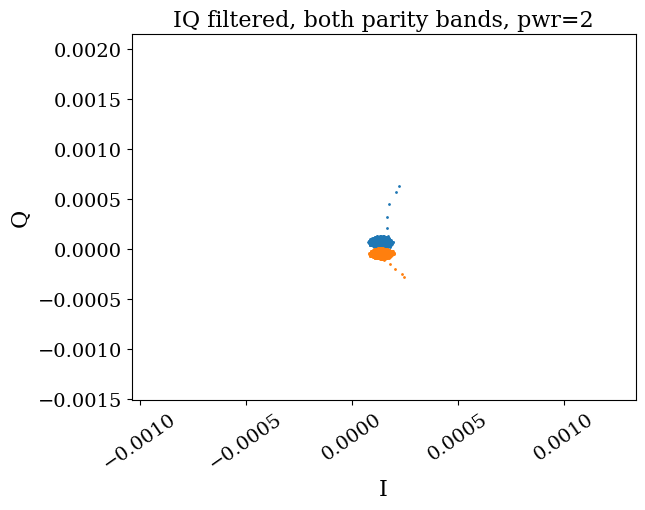

In [170]:
plt.scatter(butter_ivals_1[::100], butter_qvals_1[::100], s = 1)
plt.scatter(butter_ivals_2[::100], butter_qvals_2[::100], s = 1)
#plt.axis([-.0004,.0004,-.0004,.0004])
plt.tick_params(axis='x', labelrotation=35) # Rotate x-axis labels by 45 degrees
plt.tight_layout()
plt.xlabel('I')
plt.ylabel('Q')
plt.title('IQ filtered, both parity bands, pwr=2')

Text(0.5, 1, 'IQ, both parity bands, pwr=2')

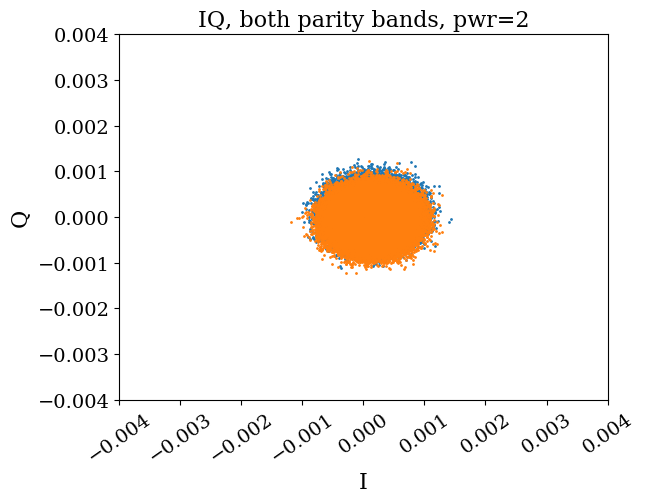

In [161]:
plt.scatter(np.real(iq_1)[::100], np.imag(iq_1)[::100], s = 1)
plt.scatter(np.real(iq_2)[::100], np.imag(iq_2)[::100], s = 1)
plt.axis([-.004,.004,-.004,.004])
plt.tick_params(axis='x', labelrotation=35) # Rotate x-axis labels by 45 degrees
plt.tight_layout()
plt.xlabel('I')
plt.ylabel('Q')
plt.title('IQ, both parity bands, pwr=2')

Notice the weird data points that look like trails or tails to the IQ blobs. What timescale are these points?

Text(0.5, 1, 'IQ, both parity bands; first 3500 data points')

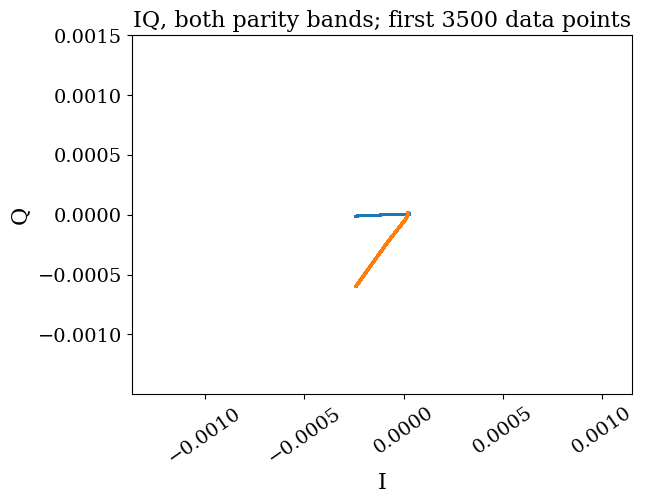

In [67]:
indx_slicer = 3500
plt.scatter(butter_ivals_1[:indx_slicer], butter_qvals_1[:indx_slicer], s = 1)
plt.scatter(butter_ivals_2[:indx_slicer], butter_qvals_2[:indx_slicer], s = 1)
#plt.axis([-.0004,.0004,-.0004,.0004])
plt.tick_params(axis='x', labelrotation=35) # Rotate x-axis labels by 45 degrees
plt.tight_layout()
plt.xlabel('I')
plt.ylabel('Q')
plt.title('IQ, both parity bands; first {} data points'.format(indx_slicer))

Timescale of those weird dots (seconds):

In [38]:
3000 / (S.get_channel_frequency_mhz(0) * 1e6)

0.00125

In [51]:
S.which_on(0)

array([ 32, 192])

Total time of acquisition (seconds):

In [29]:
len(iq_2)/(S.get_channel_frequency_mhz(0) * 1e6)

13.981013333333333

In [46]:
sync_1.shape

(33554432, 2)

In [49]:
S.get_number_processed_channels(0)

416

In [50]:
S.get_number_sub_bands(0)

512

In [52]:
2**25

33554432

In [47]:
S.take_debug_data??

Signature:
S.take_debug_data(
    band,
    channel=None,
    nsamp=524288,
    filename=None,
    IQstream=1,
    single_channel_readout=1,
    debug=False,
    rf_iq=False,
    write_log=True,
)
Source:   
    @set_action()
    def take_debug_data(self, band, channel=None, nsamp=2**19, filename=None,
            IQstream=1, single_channel_readout=1, debug=False, rf_iq=False,
            write_log=True):
        """Takes raw debugging data.

        Args
        ----
        band : int
            The band to take data on.
        channel : int or None, optional, default None
            The channel to take debug data on in single_channel_mode.
        nsamp : int, optional, default 2**19
            The number of samples to take.
        filename : str or None, optional, default None
            The name of the file to save to.
        IQstream : int, optional, default 1
            Whether to take the raw IQ stream.
        single_channel_readout : int, optional, default 1
         

### Playing around with channel mode and setting channel to None

I have no idea what channel_mode does, and epics documentation has nothing on it. I'd also like to know what happens with setting channel = None. Let's take debug data in each case and compare.

channel_mode = 1

In [25]:
iq_1, sync_1, filename_1 = takeDebugData(S, band=band_1, channel=channel_1, nsamp=2**25, 
                                   plot=False, show_plot=False, channel_mode=1)

iq_2, sync_2, filename_2 = takeDebugData(S, band=band_2, channel=channel_2, nsamp=2**25, 
                                   plot=False, show_plot=False, channel_mode=1)

fs_1 = S.get_channel_frequency_mhz(band_1) * 1.0E6
fs_2 = S.get_channel_frequency_mhz(band_2) * 1.0E6

cutoff_hz = 500
order = 2

butter_ivals_1 = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.real(iq_1), fs=fs_1)
butter_qvals_1 = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.imag(iq_1), fs=fs_1)

butter_ivals_2 = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.real(iq_2), fs=fs_2)
butter_qvals_2 = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.imag(iq_2), fs=fs_2)

[ 2025-11-17 23:42:58 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 32
[ 2025-11-17 23:42:59 ]  Writing to file : /data/smurf_data/20251117/1763422819/outputs/1763422979_single_channel_b0ch032.dat
[ 2025-11-17 23:42:59 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 33554432
[ 2025-11-17 23:42:59 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2025-11-17 23:42:59 ]  Data acquisition in progress...
[ 2025-11-17 23:42:59 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2025-11-17 23:43:15 ]  Done taking data
[ 2025-11-17 23:43:26 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 192
[ 2025-11-17 23:43:26 ]  Writing to file : /data/smurf_data/20251117/1763422819/outputs/1763423007_single_channel_b0ch192.dat
[ 2025-11-17 23:43:26 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 3

In [26]:
S.get_channel_frequency_mhz(0)

2.4

In [28]:
iq_2.shape

(33554432,)

Text(0.5, 1, 'IQ, both parity bands')

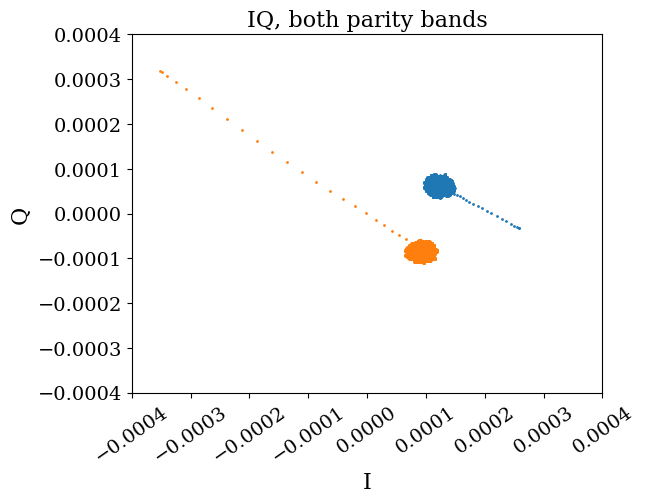

In [27]:
plt.scatter(butter_ivals_1[::100], butter_qvals_1[::100], s = 1)
plt.scatter(butter_ivals_2[::100], butter_qvals_2[::100], s = 1)
plt.axis([-.0004,.0004,-.0004,.0004])
plt.tick_params(axis='x', labelrotation=35) # Rotate x-axis labels by 45 degrees
plt.tight_layout()
plt.xlabel('I')
plt.ylabel('Q')
plt.title('IQ, both parity bands')

channel_mode = 0

In [15]:
iq_1, sync_1, filename_1 = takeDebugData(S, band=band_1, channel=channel_1, nsamp=2**25, 
                                   plot=False, show_plot=False, channel_mode=0)

iq_2, sync_2, filename_2 = takeDebugData(S, band=band_2, channel=channel_2, nsamp=2**25, 
                                   plot=False, show_plot=False, channel_mode=0)

fs_1 = S.get_channel_frequency_mhz(band_1) * 1.0E6
fs_2 = S.get_channel_frequency_mhz(band_2) * 1.0E6

cutoff_hz = 500
order = 2

butter_ivals_1 = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.real(iq_1), fs=fs_1)
butter_qvals_1 = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.imag(iq_1), fs=fs_1)

butter_ivals_2 = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.real(iq_2), fs=fs_2)
butter_qvals_2 = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.imag(iq_2), fs=fs_2)

[ 2025-11-18 00:07:44 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 32
[ 2025-11-18 00:07:44 ]  Writing to file : /data/smurf_data/20251118/1763424417/outputs/1763424465_single_channel_b0ch032.dat
[ 2025-11-18 00:07:44 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 33554432
[ 2025-11-18 00:07:44 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2025-11-18 00:07:44 ]  Data acquisition in progress...
[ 2025-11-18 00:07:45 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2025-11-18 00:08:01 ]  Done taking data
[ 2025-11-18 00:08:11 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 192
[ 2025-11-18 00:08:11 ]  Writing to file : /data/smurf_data/20251118/1763424417/outputs/1763424492_single_channel_b0ch192.dat
[ 2025-11-18 00:08:11 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 3

In [21]:
iq_2.shape

(33554432,)

In [22]:
S.which_on(0)

array([ 32, 192])

Text(0.5, 1, 'IQ, both parity bands')

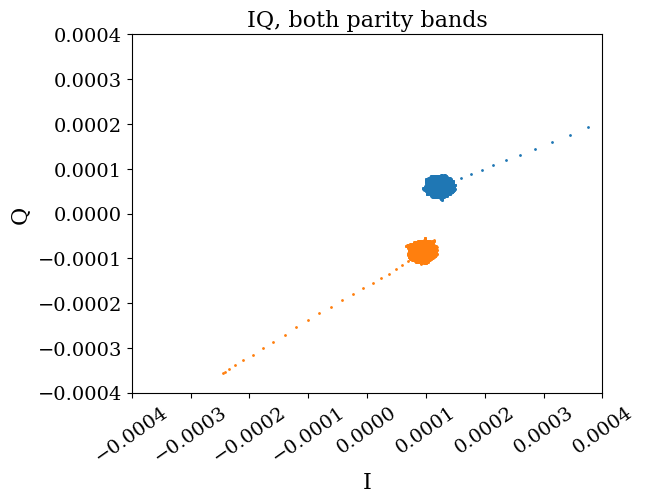

In [16]:
plt.scatter(butter_ivals_1[::100], butter_qvals_1[::100], s = 1)
plt.scatter(butter_ivals_2[::100], butter_qvals_2[::100], s = 1)
plt.axis([-.0004,.0004,-.0004,.0004])
plt.tick_params(axis='x', labelrotation=35) # Rotate x-axis labels by 45 degrees
plt.tight_layout()
plt.xlabel('I')
plt.ylabel('Q')
plt.title('IQ, both parity bands')

Like in Shawn's multitone code, let's do channel = None and channel_mode = 1

In [16]:
iq_1, _, filename_1 = takeDebugData(S, band=band_1, channel=None, nsamp=2**25, 
                                   plot=False, show_plot=False, channel_mode=1)

iq_2, _, filename_2 = takeDebugData(S, band=band_2, channel=None, nsamp=2**25, 
                                   plot=False, show_plot=False, channel_mode=1)

fs_1 = S.get_channel_frequency_mhz(band_1) * 1.0E6
fs_2 = S.get_channel_frequency_mhz(band_2) * 1.0E6

cutoff_hz = 500
order = 2

butter_ivals_1 = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.real(iq_1), fs=fs_1)
butter_qvals_1 = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.imag(iq_1), fs=fs_1)

butter_ivals_2 = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.real(iq_2), fs=fs_2)
butter_qvals_2 = butterworth_filter(cutoff_hz=cutoff_hz, order=order, data=np.imag(iq_2), fs=fs_2)

[ 2025-11-17 23:57:04 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadout 0
[ 2025-11-17 23:57:04 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadoutOpt2 0
[ 2025-11-17 23:57:04 ]  Writing to file : /data/smurf_data/20251117/1763423765/outputs/1763423824_multi_channel_b0.dat
[ 2025-11-17 23:57:04 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 33554432
[ 2025-11-17 23:57:04 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2025-11-17 23:57:04 ]  Data acquisition in progress...
[ 2025-11-17 23:57:04 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2025-11-17 23:57:10 ]  Done taking data
[ 2025-11-17 23:57:18 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadout 0
[ 2025-11-17 23:57:18 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChan

In [17]:
iq_2.shape

(33554432,)

Text(0.5, 1, 'IQ, both parity bands')

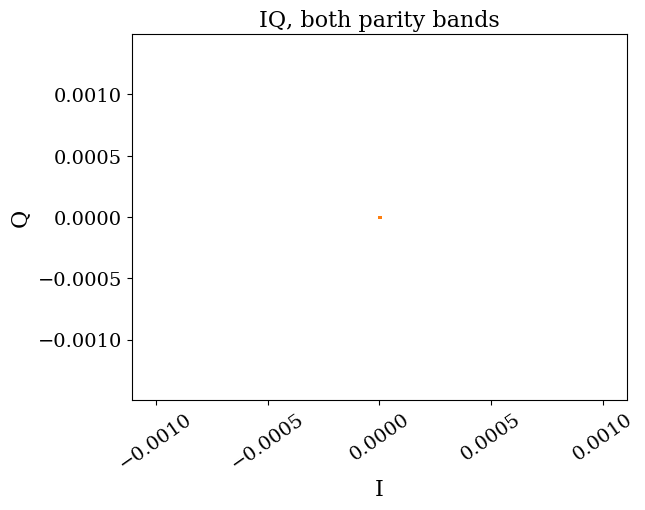

In [19]:
plt.scatter(butter_ivals_1[::100], butter_qvals_1[::100], s = 1)
plt.scatter(butter_ivals_2[::100], butter_qvals_2[::100], s = 1)
#plt.axis([-.0004,.0004,-.0004,.0004])
plt.tick_params(axis='x', labelrotation=35) # Rotate x-axis labels by 45 degrees
plt.tight_layout()
plt.xlabel('I')
plt.ylabel('Q')
plt.title('IQ, both parity bands')

# let's move the tone away from the SQUAT

In [38]:
m1 = -90.3

In [39]:
S.all_off()
S.log('trying to do a PSD thing')
amp_readout_freq = 595.2+m1-40
my_log = f'Sending fixed tone at {amp_readout_freq} MHz'
print(my_log)
S.log(my_log)

(band,channel)=S.set_fixed_tone(amp_readout_freq,12)

[ 2025-10-16 01:49:09 ]  Turning off tones
[ 2025-10-16 01:49:25 ]  Turning off flux ramp
[ 2025-10-16 01:49:25 ]  Turning off all TES biases
[ 2025-10-16 01:49:25 ]  trying to do a PSD thing
Sending fixed tone at 464.90000000000003 MHz
[ 2025-10-16 01:49:25 ]  Sending fixed tone at 464.90000000000003 MHz


AssertionError: ! Requested frequency (=464.9 MHz) outside of the 500 MHz band with the closest band center (=4250 MHz). Doing nothing!

In [ ]:
iq, sync, filename = takeDebugData(S, band=band, channel=channel, nsamp=2**25, 
                                   plot=True, show_plot=True, channel_mode=2)

In [ ]:
fs = S.get_channel_frequency_mhz(band) * 1.0E6

ffamp, pxxa = welch(np.abs(iq),fs=fs, nperseg=2**18)
ffphase, pxxph = welch(np.angle(iq),fs=fs, nperseg=2**18)



timestamp = S.get_timestamp() 
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
plt.gca().loglog(ffphase,pxxph, linestyle='--',label=f'phase {filename}')
plt.ylabel('phase psd')
plt.xlabel('Frequency (Hz)')
plt.title(filename)
plt.show()

plt.gca().loglog(ffamp,pxxa,linestyle='-',label=f'amp {filename}')
plt.ylabel('amp psd')
plt.xlabel('Frequency (Hz)')
plt.title(filename)

In [40]:
curoff_hz = 500
order = 2

fs = S.get_channel_frequency_mhz(band) * 1.0E6

def butterworth_filter(data, fs, cutoff_hz=200, order=1):
    b, a = butter(N=order, Wn=cutoff_hz, btype='low', fs=fs)
    zi = sp.signal.lfilter_zi(b, a)
    filt_data, _ = sp.signal.lfilter(b, a, data, zi=zi*data[0])
    return filt_data

butter_ivals = butterworth_filter(cutoff_hz=curoff_hz, order=order, data=np.real(iq), fs=fs)
butter_qvals = butterworth_filter(cutoff_hz=curoff_hz, order=order, data=np.imag(iq), fs=fs)

NameError: name 'band' is not defined

In [41]:
start_plot_time_s = 0.1
stop_plot_time_s = 1

## Find indices that best match times
times = np.arange(len(iq)) / fs
start_plot_idx = np.argmin(np.abs(times - start_plot_time_s))
stop_plot_idx = np.argmin(np.abs(times - stop_plot_time_s))

fig, ax = plt.subplots(4,1, figsize=(12,15), sharex=True)
ax[0].plot(times[start_plot_idx:stop_plot_idx], butter_ivals[start_plot_idx:stop_plot_idx], '.',label='I', markersize=0.4)
ax[0].set_ylabel(['Ivals'])

ax[1].plot(times[start_plot_idx:stop_plot_idx], butter_qvals[start_plot_idx:stop_plot_idx],'.', label='Q', markersize=0.4)
ax[1].set_ylabel(['Qvals'])

ax[2].plot(times[start_plot_idx:stop_plot_idx], np.abs(butter_ivals+1j*butter_qvals)[start_plot_idx:stop_plot_idx], '.', label='amp', markersize=0.4)
ax[2].set_ylabel(['amp'])

ax[3].plot(times[start_plot_idx:stop_plot_idx], np.unwrap(np.angle(butter_ivals+1j*butter_qvals)[start_plot_idx:stop_plot_idx]), '.', label='phase', markersize=0.4)
ax[3].set_ylabel(['phase'])
ax[3].set_xlabel('Time [s]')

fig.suptitle(f'{filename} filtered to {curoff_hz} Hz')

plt.show()

NameError: name 'iq' is not defined